In [51]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

In [52]:
import sqlite3

In [53]:
import psycopg2
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [54]:
connection = psycopg2.connect(user="student",
                              # пароль, который указали при установке PostgreSQL
                              password="JvLda93aA",
                              host="158.160.52.106",
                              port="5432",
                              database="postgres")


In [55]:
df = pd.read_sql('''
select
	c.client_rk,
	c.visit_dttm::date as visit_dt,
    date_trunc('month', visit_dttm)::date as visit_mth,
    date_trunc('week', visit_dttm)::date as visit_week,
	max(case when registration_dttm::date is not null then 1 else 0 end) as reg_flg,
	max(case when application_dttm::date is not null then 1 else 0 end) as appl_flg,
	max(case when game_flg=1 then 1 else 0 end) as game_flg,
	max(case when finish_flg=1 then 1 else 0 end) as finish_flg
	from msu_analytics.client c 
	left join msu_analytics.account a 
		on c.client_rk=a.client_rk 
	left join msu_analytics.application ap 
		on a.account_rk=ap.account_rk 
	left join msu_analytics.game g 
		on g.game_rk=ap.game_rk 
    group by 1,2,3,4
	;
''', connection)

C:\Anaconda\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [58]:
df.head()

,client_rk,visit_dt,visit_mth,visit_week,reg_flg,appl_flg,game_flg,finish_flg
0,1216,2022-10-05,2022-10-01,2022-10-03,0,0,0,0
1,1885,2022-09-30,2022-09-01,2022-09-26,1,0,0,0
2,2035,2022-10-28,2022-10-01,2022-10-24,0,0,0,0
3,181,2022-09-17,2022-09-01,2022-09-12,0,0,0,0
4,1116,2022-11-24,2022-11-01,2022-11-21,0,0,0,0


In [59]:
df_week = (df
            .groupby('visit_week')
            .agg({'client_rk':'nunique', 'reg_flg':'mean', 'appl_flg':'mean', 'game_flg':'mean'})
            .reset_index()
           )

In [60]:
df_month = (df
            .groupby('visit_mth')
            .agg({'client_rk':'nunique', 'reg_flg':'mean', 'appl_flg':'mean', 'game_flg':'mean'})
            .reset_index()
           )

In [61]:
df_month[['reg_flg', 'appl_flg', 'game_flg']] = df_month[['reg_flg', 'appl_flg', 'game_flg']]*100

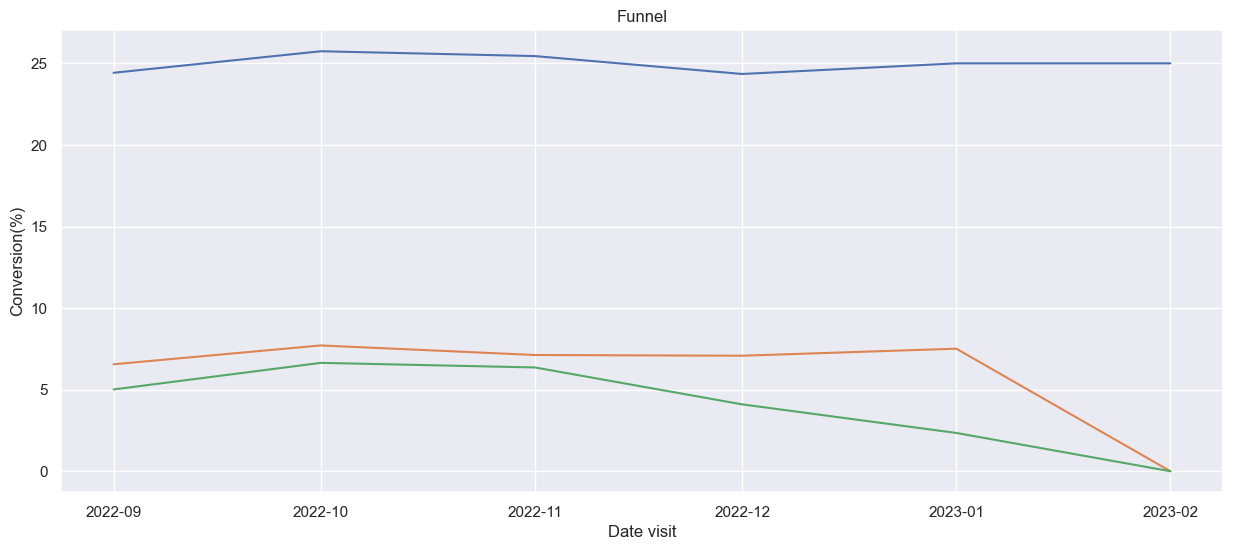

In [62]:
sns.set (rc={"figure.figsize":( 15 , 6 )})
ax = sns.lineplot(data = df_month, x = 'visit_mth', y = 'reg_flg')
ax.set(xlabel = "Date visit", ylabel = "Conversion(%)", title='Funnel');
sns.lineplot(data = df_month, x = 'visit_mth', y = 'appl_flg')
sns.lineplot(data = df_month, x = 'visit_mth', y = 'game_flg');

In [63]:
df_week[['reg_flg', 'appl_flg', 'game_flg']] = df_week[['reg_flg', 'appl_flg', 'game_flg']]*100

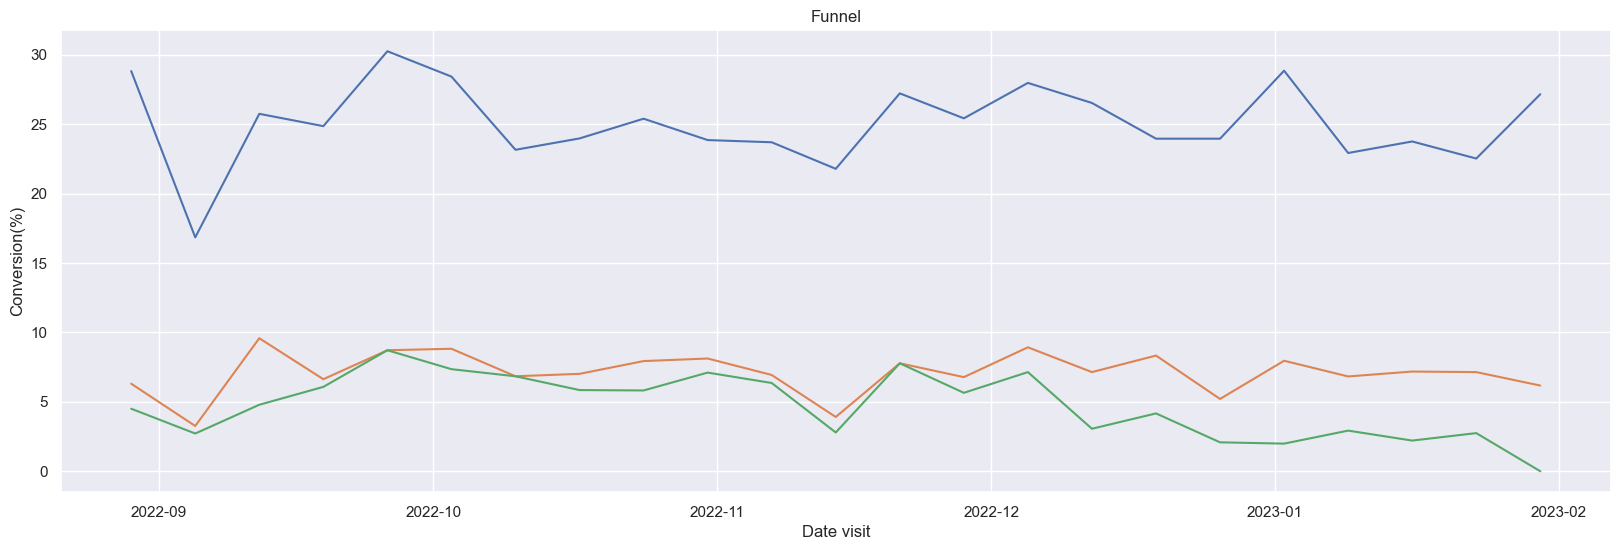

In [64]:
sns.set (rc={"figure.figsize":( 20 , 6 )})
ax = sns.lineplot(data = df_week, x = 'visit_week', y = 'reg_flg');
ax.set(xlabel = "Date visit", ylabel = "Conversion(%)", title='Funnel');
sns.lineplot(data = df_week, x = 'visit_week', y = 'appl_flg')
sns.lineplot(data = df_week, x = 'visit_week', y = 'game_flg');


Из построенных графиков можно сделать следующие выводы:
1. Регистрируется на сайте только примерно 25% посетителей
2. Число посетителей сайта со временем не растет
3. На неделе в ноябре была резкая просадка по конверсии в заявку, возможно есть какой-то баг, который нужно исправить
4. В сентябре есть неделя, где резко упали регистрации, возможно была какая-то ошибка

Точки роста продукта:
1. Привлечение новой аудитории (посещения сайта не растут, надо развивать привлечение)
2.В продукте очень малая конверсия на этапе регистрации на сайт. На моменте, как клиент зашел на сайт, нужно как то замотивировать его, дабы он зарегистрировался на сайте и тогда прибыль с других этапов должна вырасти.